# SCI6485 Introduction to Generative Artificial Intelligence

##  Homework: Train a Variational Autoencoder on your custom custome dataset


**Harvard University**<br/>
**Fall 2023**<br/>
**Instructor:**  Sabrina Osmany<br/>
**TA:**  Jiabin Wei<br/>

**DISCLAIMER**: No public reproduction of this code is allowed without the explicit consent of their authors.

<hr style="height:2pt">

---

# Instructions
1. This colab is provided to you as a template. If you download the dataset linked below in this example and follow the instructions to upload the dataset, you should be able to run all the code without any errors.
2. You cannot edit this colab directly. You should save it as a copy in your google drive or copy paste the code to your own colab.
3. You are expected to upload your own custom dataset and train a new CNN classification model. Datasets are available on Kaggle.com for experimentation.
4. We highlight the parameters and part you should work with:
```
#######################################################
#      you should do something to the code below
#######################################################
```
But please feel free to moodify other parts.

5. The green texts with a `#` in the front of the line are comments/explanation for the code below it. You could delete all the comments if you don't need it.
6. To quickly jump to the part you want read, you can use the table of contents feature on the left-hand sidebar.
7. You should be able to find detailed explanation of everything about Pytorch [here](https://pytorch.org/tutorials/). The searching bar on the left-hand side in this website is really helpful for you find the documenation for specific functions/methods of Pytorch.

In [ ]:
import torch
# make the code reproducible
torch.backends.cudnn.deterministic = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)

import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

# Load data

## Read CIFAR10 data

In [ ]:
data_dir = 'dataset'
batch_size = 64
resize_img = 28

# set the transform function
transform = transforms.Compose([
                              transforms.Resize(size=resize_img),
                              transforms.ToTensor(),
                              # Normalize all channel values to [0,1]
                              transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])

# get training dataset and save the image to your colab root directory
train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=transform)
# get testing dataset and save the image to your colab root directory
test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True, transform=transform)



classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# we only use one category to train the VAE. The number below indicates the index of the category in the class list
selected_classes = [1,]

# Filter the dataset to keep only the selected classes
train_dataset.data = [x for i, x in enumerate(train_dataset.data) if train_dataset.targets[i] in selected_classes]
train_dataset.targets = [y for y in train_dataset.targets if y in selected_classes]

# split to get train data and validation data
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


# Filter the dataset to keep only the selected classes
test_dataset.data = [x for i, x in enumerate(test_dataset.data) if test_dataset.targets[i] in selected_classes]
test_dataset.targets = [y for y in test_dataset.targets if y in selected_classes]

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print(len(train_data))
print(len(val_data))
print(len(test_dataset))

# subset_size = 20000
# # Create a random sampler to select a subset of the dataset
# subset_sampler = torch.utils.data.RandomSampler(trainset, num_samples=subset_size, replacement=False)

# # Use a DataLoader with the sampler to load the subset
# subset_loader = torch.utils.data.DataLoader(subset_sampler, batch_size=batch_size, sampler=subset_sampler)



Files already downloaded and verified
Files already downloaded and verified
4000
1000
1000


torch.Size([64, 3, 28, 28])


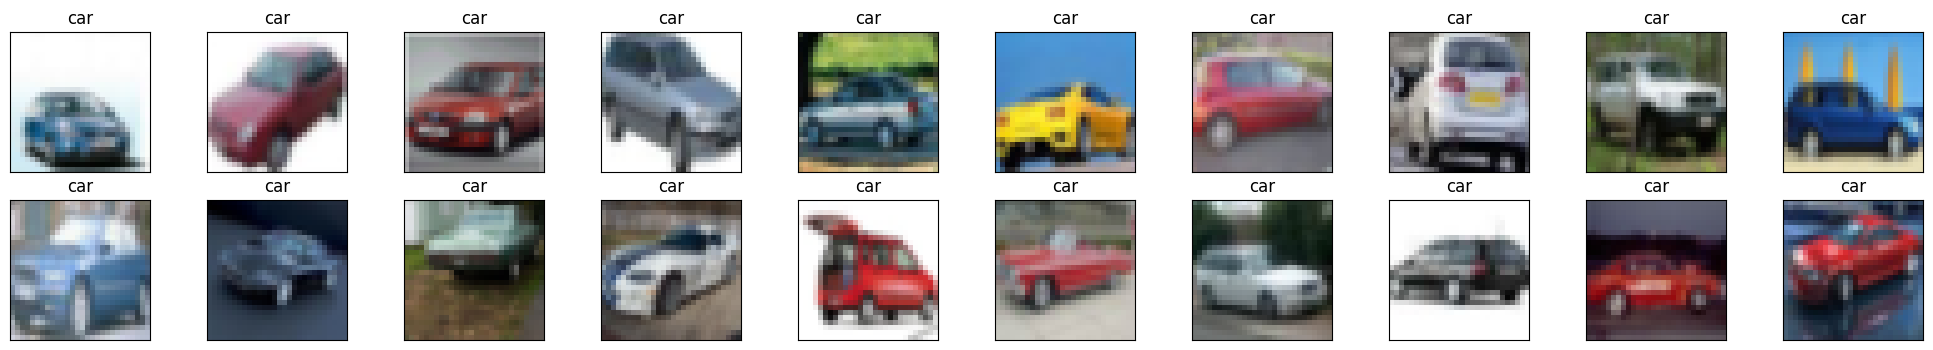

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def im_convert(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    return image

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# check batch size
print(images.shape)

# show images
fig = plt.figure(figsize=(25, 4))
# We plot 20 images from our train_dataset
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
    ax.set_title(classes[labels[idx].item()])

## Load custom dataset

The way we load custom data is very similar to the previous HW. There are two ways to do it. In this HW, we suggest you to use the put your dataset on your google drive as you probably need more images to train the model (>1000). You first upload your dataset to a specific directory on your google drive and then mount your google drive to your colab directory.

The dataset structure will remain the same as last time. Even though you only have one category, you still need a sub folder to put all your images under your parent dataset folder.

In [ ]:
#######################################################
# Option_1: upload your dataset zip file to the colab `content` folder. If you upload the folder directory, then skip this step
#######################################################
!unzip images.zip
# use this line if you want to unzip it to a specific folder
# !unzip data.zip -d your_specific_directory

In [ ]:
#######################################################
# Option_2: mount your google dirve and access dataset in your drive folder
#######################################################
# Mount your google drive to colab conent directory
from google.colab import drive
drive.mount('/content/drive/')

# set the folder where your store your dataset as the root directory
import os
os.chdir('/content/drive/MyDrive/MDE/SCI6485/datasets/')

# This code will show your dataset folder and anything in the root directory you just set above
!ls

Mounted at /content/drive/
anime_face  images.zip	__MACOSX


In [ ]:
import pandas as pd
import os
from PIL import Image


#######################################################
#               set your data directory
#######################################################
root_directory = "" # if you save the data to the current root directory, you can leave this variable as it is
# we use this dataset as an example: https://www.kaggle.com/datasets/splcher/animefacedataset
dataset_path = root_directory + "anime_face/"

#######################################################
#             set your data class list
#######################################################
# set your image labels. The class name should be the same as the class folder name under your dataset directory
class_list = ['all']
selected_classes = [0,]

# we generate a dataframe to store all your image pathes and the corresponding labels.
image_name_list = []
image_label = []
max_image_number = 5000
n = 0
exceed_maximum = False
# print(os.listdir("/"))
for class_name in os.listdir(dataset_path):
    if not class_name.startswith('.') and not exceed_maximum:
        for image in os.listdir(dataset_path + class_name + '/'):
            if not image.startswith('.'):
                image_name_list.append(dataset_path + class_name + '/' + image)
                image_label.append(class_name)
                n += 1
                if n >= max_image_number:
                    exceed_maximum = True
                    break
    else:
        break

dataset_df = pd.DataFrame(columns=["img_name","label"])
dataset_df["img_name"] = image_name_list
dataset_df["label"] = image_label


#######################################################
#                 set your csv name
#######################################################
#    we save the dataframe as a csv file and save it to the root directory of colab
csv_name = 'dataset_csv.csv'
dataset_df.to_csv (root_directory + csv_name, index = False, header=True)
print(dataset_df)

                           img_name label
0     anime_face/all/62620_2019.jpg   all
1     anime_face/all/63073_2019.jpg   all
2      anime_face/all/6366_2003.jpg   all
3      anime_face/all/6325_2003.jpg   all
4      anime_face/all/6401_2003.jpg   all
...                             ...   ...
4995   anime_face/all/5547_2003.jpg   all
4996  anime_face/all/54258_2016.jpg   all
4997  anime_face/all/54991_2016.jpg   all
4998  anime_face/all/55195_2016.jpg   all
4999  anime_face/all/55057_2016.jpg   all

[5000 rows x 2 columns]


In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CustomeDataset(Dataset):
    def __init__(self, root_dir, annotation_file, class_list, subclass_list=None, transform=None):
        self.root_dir = root_dir
        if subclass_list is not None:
            # Use list comprehension to get the corresponding items
            selected_items = [class_list[i] for i in subclass_list]
            csv_df = pd.read_csv(annotation_file)
            self.annotations = csv_df[csv_df['label'].isin(selected_items)]
        else:
            self.annotations = pd.read_csv(annotation_file)
        self.class_list = class_list
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        image_id = self.annotations.iloc[index, 0]
        image = Image.open(os.path.join(self.root_dir, image_id)).convert("RGB")
        label = self.class_list.index(self.annotations.iloc[index, 1])

        if self.transform is not None:
            image = self.transform(image)

        return (image, label)


#######################################################
#        set the image size for training
#######################################################
# if you plan to use the resnet model then you need to set it as 224.
# If you change to a different number, you need to modify the linear layer dimension in the model. It will be a hustle, but would super helpful for you understand the structure of the model.
resize_img = 224

# This  transformation is used to create more data samples from your existng dataset.
# We will later add these transformed samples to the dataset to increase the total number of samples for training.
# This is called data augmentation
transform = transforms.Compose([
                              # set the height or width (which one is smaller) to 100 (the aspect ratio stays the same)
                              transforms.Resize(size=resize_img),
                              # crop the image from the centroid and resize them to 100*100
                              transforms.CenterCrop((resize_img,resize_img)),
                              transforms.ToTensor(),
                              # Normalize all channel values to [0,1]
                              transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])


# create your custom Pytorch dataset
dataset = CustomeDataset(root_directory, root_directory + csv_name, class_list, subclass_list=selected_classes, transform=transform)
print(len(dataset))



5000


In [ ]:
#######################################################
#        set some parameters to process the data
#######################################################
# load dataset
batch_size = 64
train_percentage = 0.7
augmentation_train_dataset = True
augmentation_merge = True

# randomly split the dataset.
train_size = int(train_percentage * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size, test_size])

# further split to get train data and validation data
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

print(len(train_data))
print(len(val_data))
print(len(test_dataset))


2800
700
1500


torch.Size([64, 3, 224, 224])


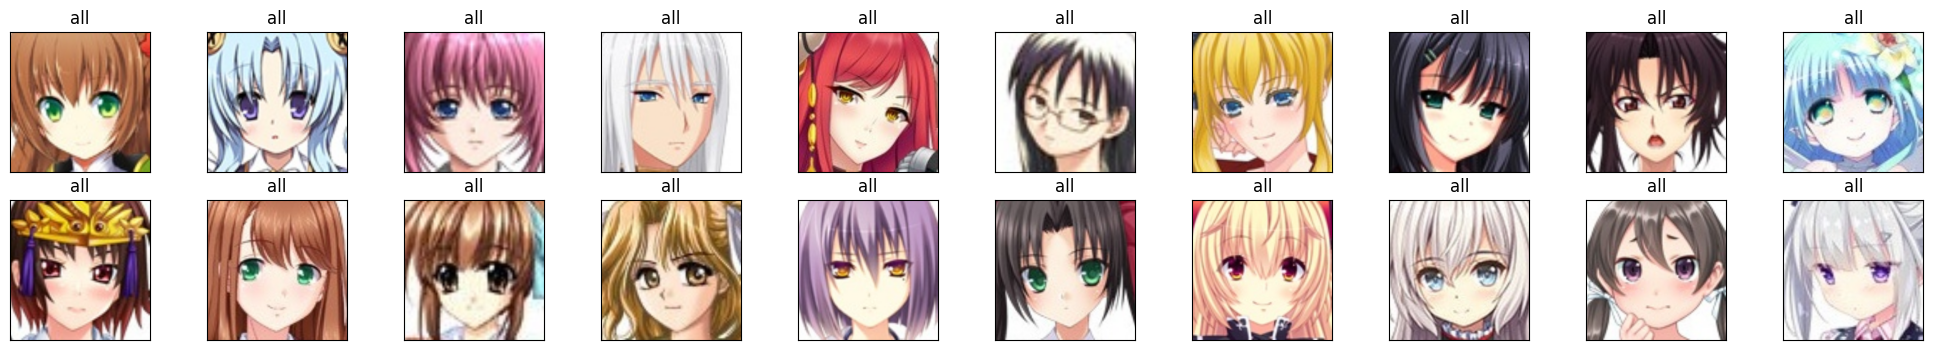

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def im_convert(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    return image

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# check batch size
print(images.shape)

# show images
fig = plt.figure(figsize=(25, 4))
# We plot 20 images from our train_dataset
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
    ax.set_title(class_list[labels[idx].item()])

# Build a simple CNN VAE model

## Build VAE for rgb images

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, device, in_channels=1):
        super(VariationalEncoder, self).__init__()

        #######################################################
        #        Customize the encoder:
        #        you could build your own linear layers
        #######################################################

        self.conv1 = nn.Conv2d(in_channels, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)

        # This a batch normalization layer. it will improve training stability and convergence.
        # typically applied to individual layers after a linear transformation and before the activation function.
        self.batch2 = nn.BatchNorm2d(64)

        # Linear Layer for Mean (mu) of Latent Space
        self.linear_mu = nn.Linear(7*7*64, latent_dims)
        # Linear Layer for Log-Variance (logvar) of Latent Space
        self.linear_logvar = nn.Linear(7*7*64, latent_dims)

        self.relu = nn.ReLU()

        # variable to store Kullback–Leibler (KL) divergence
        self.kl = 0

    def forward(self, x):
        x = x.to(device)

        #######################################################
        #        Customize the encoder:
        #        connect your layers
        #######################################################
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = F.relu(self.batch2(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)

        # 1) The encoder produces a mean value (mu) for each dimension of the latent space, which represents the center of a Gaussian distribution in that dimension.
        mu =  self.linear_mu(x)
        # 2) The encoder also produces a log-variance value (logvar) for each dimension, which is often treated as a learned offset to the Gaussian's log-variance.
        logvar = self.linear_logvar(x)
        # It's common to work with the logarithm of the variance (log-variance) rather than the standard deviation (sigma) directly
        # reason 1: the log-variance can take on any real value, which is important because it allows the model to capture both small and large variances effectively.
        # reason 2: optimization algorithms like gradient descent often beneficial to work with quantities that are centered around zero. Taking the logarithm helps center the values around zero and avoids issues with extremely small or large numbers.

        # 3) During the sampling process (when generating latent vectors), you exponentiate the logvar to obtain the standard deviation (sigma) of the Gaussian distribution.
        std = torch.exp(0.5 *logvar)

        # 4) You then sample from this Gaussian distribution with mean (mu) and standard deviation (sigma) to generate a latent vector.
        # a latent vector is sampled from this probability distribution
        # Each element of eps will be a random value sampled from a standard normal distribution (mean 0, standard deviation 1)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)

        # add an auxillary loss that penalizes the distribution P(z|x) for being to far from the N(0,1)
        # Kullback–Leibler (KL) divergence. https://stats.stackexchange.com/questions/500110/clarification-of-variational-autoencoderss
        # reason 1: we need this loss to train the encoder network since gradients cannot flow through sampling (which is a non-differentiable operation).
        # reason 2: we can encourage the latent vectors to occupy a more centralized and uniform location by penalizing the KL divergence
        # we could also approximate KL with monte-carlo simulation. The code is shown below.

        self.kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return z

In [ ]:
class Decoder(nn.Module):

    def __init__(self, latent_dims, in_channels=1):
        super().__init__()

        #######################################################
        #        Customize the decoder:
        #        you could build your own linear layers
        #######################################################

        self.decoder_lin = nn.Linear(latent_dims, 7 * 7 * 64)

        # reshape a flattened (1D) tensor into a multidimensional tensor
        # (64, 7, ,7) tuple representing the size of each dimension.
        # it specifies that the unflattened tensor should have a size of 32 along the first dimension and a size of 3x3 in the remaining dimensions.
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 7, 7))

        # Decoder transpose convolutional Layers
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, in_channels, 4, stride=2, padding=1),
        )

    def forward(self, x):
        #######################################################
        #        Customize the decoder:
        #        connect your layers
        #######################################################

        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, device, in_channels=1):
        super(VariationalAutoencoder, self).__init__()
        # Instantiate the Encoder
        self.encoder = VariationalEncoder(latent_dims, device, in_channels=in_channels)
        # Instantiate the Decoder
        self.decoder = Decoder(latent_dims, in_channels=in_channels)

    def forward(self, x):
        x = x.to(device)
        # Encode the input tensor to obtain a latent vector
        z = self.encoder(x)
        # Decode the latent vector to reconstruct the input
        return self.decoder(z)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


#######################################################
#        set latent dim size
#######################################################
latent_dim = 30

in_channals = 3

vae_rgb = VariationalAutoencoder(latent_dims=latent_dim, device=device, in_channels=in_channals)

lr = 1e-3

optim = torch.optim.Adam(vae_rgb.parameters(), lr=lr, weight_decay=1e-5)

vae_rgb.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_mu): Linear(in_features=3136, out_features=30, bias=True)
    (linear_logvar): Linear(in_features=3136, out_features=30, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (decoder_lin): Linear(in_features=30, out_features=3136, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
  )
)

## Train and test the model

In [ ]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Move tensor to the proper device
        x = x.to(device)
        # This line passes the input data x through the VAE model (vae) to obtain the reconstructed data x_hat
        # The VAE performs both encoding and decoding operations in this step
        x_hat = vae(x)

        # Evaluate loss：
        # the binary cross-entropy loss is calculated to measure the dissimilarity between the reconstructed data x_hat and the original input data x
        # This loss quantifies how well the VAE is able to reconstruct the input data
        reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
        # reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')  # You can use other loss functions like SSIM
        # The total loss for the batch is computed as the sum of the reconstruction loss and the Kullback-Leibler (KL) divergence term
        loss = reconstruction_loss + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    # This means that any layers within the VAE, such as dropout or batch normalization layers, will now operate in their deterministic mode
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)

            # This loss quantifies how well the VAE is able to reconstruct the input data
            reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            # reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')  # You can use other loss functions like SSIM
            # The total loss for the batch is computed as the sum of the reconstruction loss and the Kullback-Leibler (KL) divergence term
            loss = reconstruction_loss + vae.encoder.kl

            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [ ]:
# plot the original images and the recontructed images during the training process
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(im_convert(images[i].reshape((3, h, w))))
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

create two lists to store the loss history

In [ ]:
training_loss_history = []
validation_loss_history = []


 EPOCH 1/10 	 train loss 1548.072 	 val loss 1450.189

 EPOCH 2/10 	 train loss 1436.501 	 val loss 1419.806

 EPOCH 3/10 	 train loss 1420.009 	 val loss 1409.489

 EPOCH 4/10 	 train loss 1409.420 	 val loss 1402.142

 EPOCH 5/10 	 train loss 1399.262 	 val loss 1396.075

 EPOCH 6/10 	 train loss 1394.154 	 val loss 1388.296

 EPOCH 7/10 	 train loss 1389.988 	 val loss 1385.178

 EPOCH 8/10 	 train loss 1388.034 	 val loss 1383.091

 EPOCH 9/10 	 train loss 1386.129 	 val loss 1382.120

 EPOCH 10/10 	 train loss 1384.709 	 val loss 1378.786


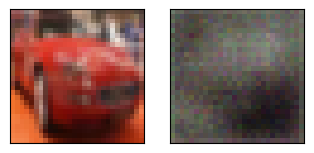

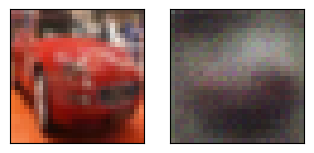

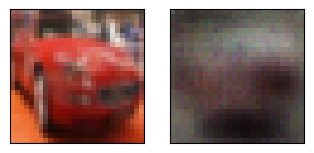

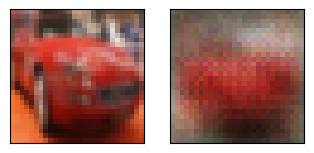

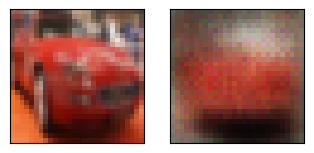

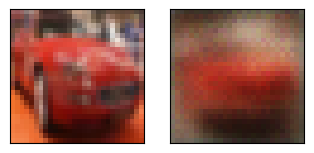

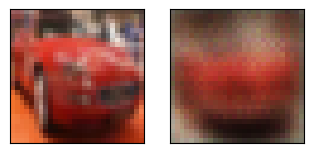

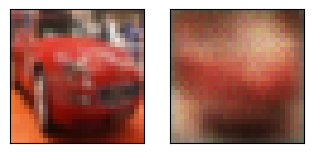

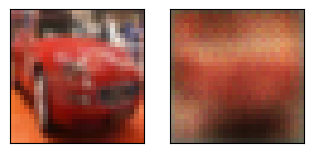

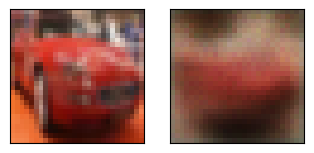

In [ ]:
#######################################################
#        set epochs
#######################################################
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train_epoch(vae_rgb, device, train_loader, optim)
    val_loss = test_epoch(vae_rgb, device, valid_loader)

    training_loss_history.append(train_loss)
    validation_loss_history.append(val_loss)

    # show an exmaple of reconstructed image
    with torch.set_grad_enabled(False):
        pic_input = train_dataset[1][0].unsqueeze(0).to(device)
        pic_output  = vae_rgb.decoder(vae_rgb.encoder(pic_input))
        pic_output = pic_output[0].squeeze()
        pic_output = pic_output.to("cpu")
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],28,28,1,2)

    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss, val_loss))


## Visualize the reconstructed images

In [ ]:
def plot_ae_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets

    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      # plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      plt.imshow(im_convert(img.cpu().squeeze()))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      # plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      plt.imshow(im_convert(rec_img.cpu().squeeze()))
      # plt.imshow(rec_img.cpu().squeeze().numpy().transpose(1, 2, 0))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

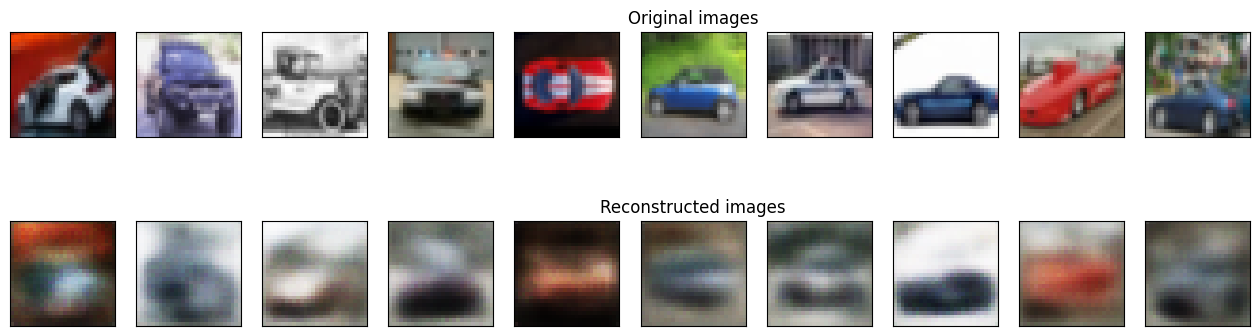

In [ ]:
plot_ae_outputs(vae_rgb.encoder, vae_rgb.decoder, n=10)

## Generate new images

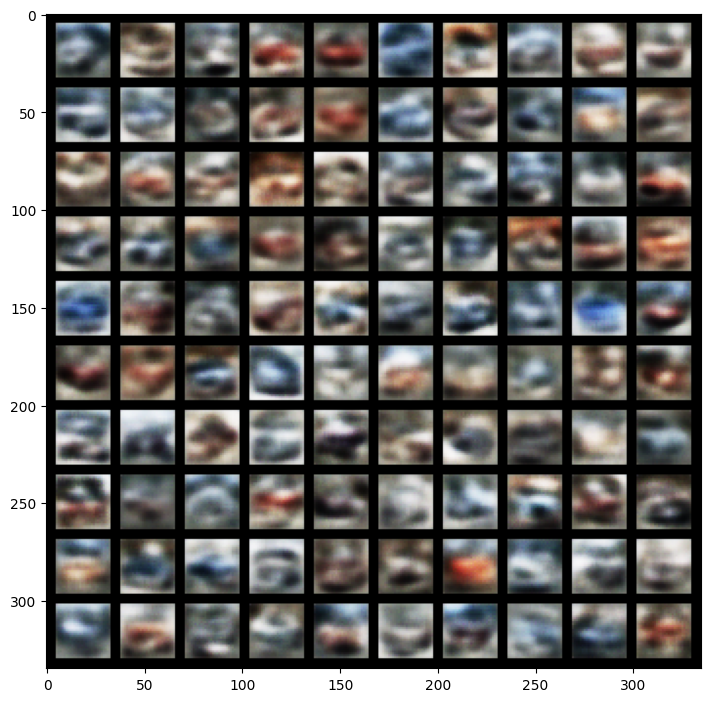

In [ ]:
def show_image(img):
    npimg = img.numpy()
    #  transposes the dimensions of the NumPy array to convert it from a PyTorch tensor format (C, H, W) to a Matplotlib format (H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sets the VAE model to evaluation mode
vae_rgb.eval()

#  temporarily disable gradient computation
with torch.no_grad():

    # sample latent vectors from the normal distribution
    # 100 random latent vectors are sampled from a standard normal distribution
    # These latent vectors will be used to generate reconstructed images
    latent = torch.randn(100, latent_dim, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae_rgb.decoder(latent)
    # After generating the reconstructed images, the data is moved to the CPU. This is often done for compatibility with Matplotlib for visualization.
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

# Use a pre-trained model

In this section, we use a pretrianed Resnet18 model as the encoder to create the VAE. We won't retrain the all the parameters inside the Resnet. Instead we only trian the fully connected linear layers inside the encoder.

This code is heavily borrowed from [here](https://github.com/hsinyilin19/ResNetVAE/tree/master)

## Resize the images to make sure the Resnet can process them

In [ ]:
#######################################################
#        if you have loaded your data and resize it to 224, you can skip this code
#######################################################
resize_img_resnet = 224
resize_transform = transforms.Compose([
                              # set the height or width (which one is smaller) to 100 (the aspect ratio stays the same)
                              transforms.Resize(size=resize_img_resnet),
                              # crop the image from the centroid and resize them to 100*100
                              transforms.CenterCrop((resize_img_resnet,resize_img_resnet)),
                              transforms.ToTensor(),
                              # Normalize all channel values to [0,1]
                              transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])

train_data.dataset.transform = resize_transform
val_data.dataset.transform = resize_transform

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,  shuffle=True, num_workers=2)

## Build resnet18-based VAE

In [ ]:
import os
from PIL import Image
import torch.utils.data as data
import torchvision.models as models
from torch.autograd import Variable

class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        # load a pretrained resnet. More models could be found: https://pytorch.org/vision/stable/models.html
        resnet = models.resnet18(pretrained=True)

        # delete the last fc layer.
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        # create our own fully connected linear layer
        # resnet.fc.in_features = 512
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)


        #######################################################
        #        Customize the encoder:
        #        These linear layers are what the model will train as the ResNet part will be frozen
        #        you could build your own linear layers
        #        if you want a better result, you probably will go for the complicated version
        #######################################################
        # Latent vectors mu and sigma
        # jb's simple version
        self.fc3_mu = nn.Linear(resnet.fc.in_features, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(resnet.fc.in_features, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # complicated version
        # self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        # self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables


        #######################################################
        #        Customize the decoder:
        #        These linear layers will be applied to the latent space before transposed convolutional layers
        #        you could build your own linear layers
        #######################################################
        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        self.fc6 = nn.Linear(self.CNN_embed_dim, 64 * 4 * 4)


        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        # ResNet
        x = self.resnet(x)
        # flatten output of conv
        x = x.view(x.size(0), -1)

        #######################################################
        #        Customize the encoder:
        #        If you build your own linear layers, you need to connect them here
        #######################################################
        # jb's Simple version
        # do nothing here

        # Complicated version
        # x = self.bn1(self.fc1(x))
        # x = self.relu(x)
        # x = self.bn2(self.fc2(x))
        # x = self.relu(x)
        ## x = F.dropout(x, p=self.drop_p, training=self.training)

        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            # Each element of eps will be a random value sampled from a standard normal distribution (mean 0, standard deviation 1)
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        #######################################################
        #        Customize the decoder:
        #        If you build your own linear layers, you need to connect them here
        #######################################################
        # jb's simple version
        x = self.fc6(z).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)

        # Complicated version
        # x = self.relu(self.fc_bn4(self.fc4(z)))
        # x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        # x = self.convTrans6(x)
        # x = self.convTrans7(x)
        # x = self.convTrans8(x)

        # no matter how big the images are from the previous layer, the next line create the image with the correct size
        # try this code with larger and smaller images
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar

In [ ]:
def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)


def loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)

        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)  # VAE
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        all_y.extend(y.data.cpu().numpy())
        all_z.extend(z.data.cpu().numpy())
        all_mu.extend(mu.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return X_reconst.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, losses


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)

            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss

            all_y.extend(y.data.cpu().numpy())
            all_z.extend(z.data.cpu().numpy())
            all_mu.extend(mu.data.cpu().numpy())
            all_logvar.extend(logvar.data.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return X_reconst.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, test_loss




## Instantiate a model

In [ ]:
# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 128     # latent dim extracted by 2D CNN
dropout_p = 0.2       # dropout probability


# training parameters
learning_rate = 1e-3
log_interval = 10   # interval for displaying training info



#######################################################
#               set your model folder
#######################################################
# save model
save_model_path = './results_custom'


# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU


# Create model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)

# Freeze the resnet part
for name, p in resnet_vae.named_parameters():
    if "resnet" in name:
        p.requires_grad = False

print("Using", torch.cuda.device_count(), "GPU!")
model_params = list(resnet_vae.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)



Using 1 GPU!


## Train the model

In [ ]:
# record training process
epoch_train_losses = []
epoch_test_losses = []
check_mkdir(save_model_path)

In [ ]:
#######################################################
#               set epochs
#######################################################
# training epochs
epochs = 10

# start training
for epoch in range(epochs):
    # train, test model
    X_reconst_train, y_train, z_train, mu_train, logvar_train, train_losses = train(log_interval, resnet_vae, device, train_loader, optimizer, epoch)
    X_reconst_test, y_test, z_test, mu_test, logvar_test, epoch_test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(epoch_test_loss)

    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)

    np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
    np.save(os.path.join(save_model_path, 'y_train_epoch{}.npy'.format(epoch + 1)), y_train)
    np.save(os.path.join(save_model_path, 'z_train_epoch{}.npy'.format(epoch + 1)), z_train)

Train Epoch: 1 [640/2800 (23%)]	Loss: 6715284.500000
Train Epoch: 1 [1280/2800 (45%)]	Loss: 6617499.000000
Train Epoch: 1 [1920/2800 (68%)]	Loss: 6508832.500000
Train Epoch: 1 [2560/2800 (91%)]	Loss: 6337097.500000
Epoch 1 model saved!

Test set (700 samples): Average loss: 103435.5529

Train Epoch: 2 [640/2800 (23%)]	Loss: 6228190.000000
Train Epoch: 2 [1280/2800 (45%)]	Loss: 6063168.000000
Train Epoch: 2 [1920/2800 (68%)]	Loss: 6076399.500000
Train Epoch: 2 [2560/2800 (91%)]	Loss: 6079905.000000
Epoch 2 model saved!

Test set (700 samples): Average loss: 100254.4157

Train Epoch: 3 [640/2800 (23%)]	Loss: 5917422.500000
Train Epoch: 3 [1280/2800 (45%)]	Loss: 6045966.500000
Train Epoch: 3 [1920/2800 (68%)]	Loss: 5986001.500000
Train Epoch: 3 [2560/2800 (91%)]	Loss: 5932633.500000
Epoch 3 model saved!

Test set (700 samples): Average loss: 97234.2479

Train Epoch: 4 [640/2800 (23%)]	Loss: 5841368.000000
Train Epoch: 4 [1280/2800 (45%)]	Loss: 5830419.500000
Train Epoch: 4 [1920/2800 (68%

## Generate new images

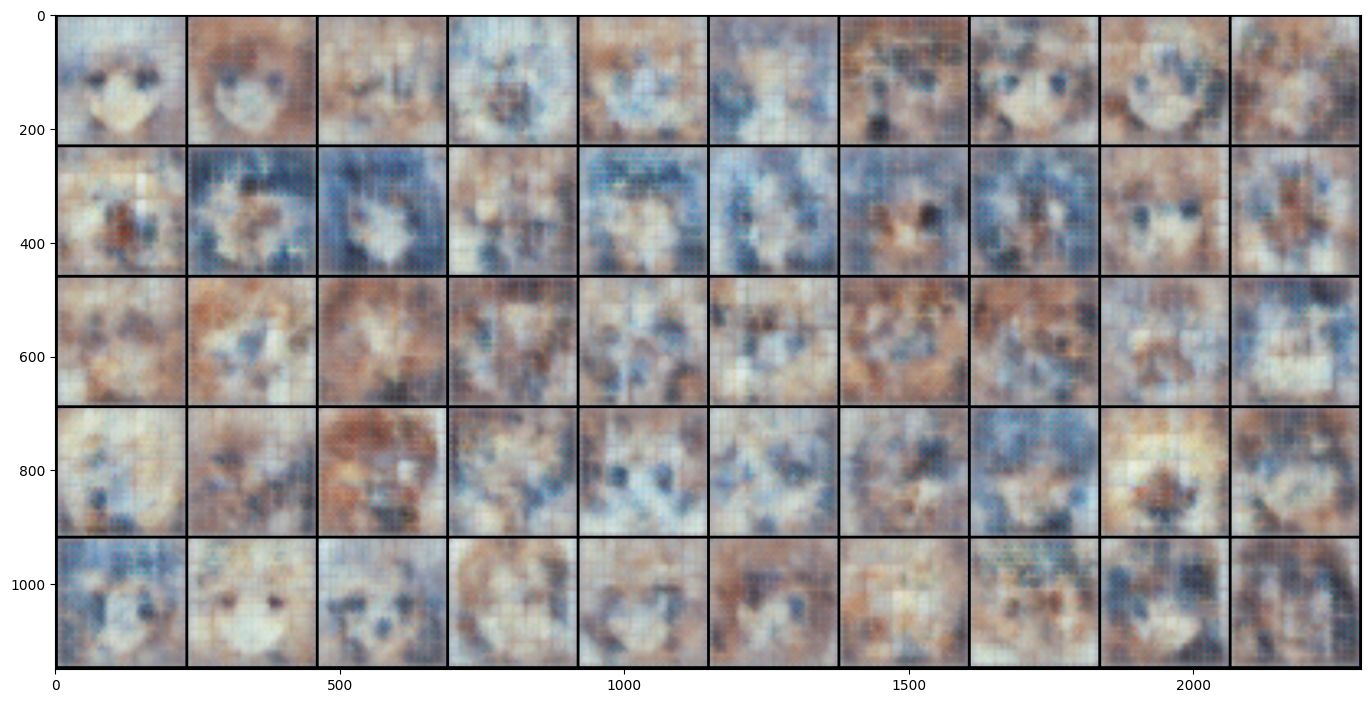

In [ ]:
def show_image(img):
    npimg = img.numpy()
    #  transposes the dimensions of the NumPy array to convert it from a PyTorch tensor format (C, H, W) to a Matplotlib format (H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sets the VAE model to evaluation mode
resnet_vae.eval()

#  temporarily disable gradient computation
with torch.no_grad():

    # sample latent vectors from the normal distribution
    # 100 random latent vectors are sampled from a standard normal distribution
    # These latent vectors will be used to generate reconstructed images
    latent = torch.randn(50, CNN_embed_dim, device=device)

    # reconstruct images from the latent vectors
    img_recon = resnet_vae.decode(latent)
    # After generating the reconstructed images, the data is moved to the CPU. This is often done for compatibility with Matplotlib for visualization.
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:50],10,5))
    plt.show()

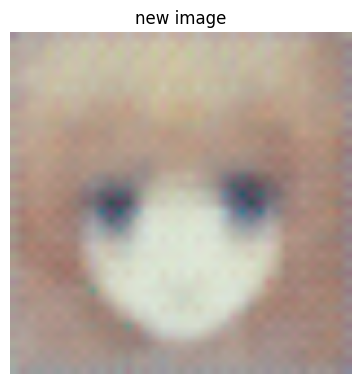

In [ ]:
# choose two original images
sample1, sample2 = 2, 5
w = 0.4 # weight for fusing two images

def decoder(model, device, z):
    model.eval()
    z = Variable(torch.FloatTensor(z)).to(device)
    new_images = model.decode(z).squeeze_().data.cpu().numpy().transpose((1, 2, 0))
    return new_images

exp = 'custom'

# generate image using decoder using two generated results during the trianing process
z_train = np.load(os.path.join(save_model_path, 'z_train_epoch{}.npy').format(epoch))
z = z_train[-sample1] * w + z_train[-sample2] * (1 - w)
new_imgs = decoder(resnet_vae, device, torch.from_numpy(z).view(1, -1))

fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 3)
plt.imshow(new_imgs)
plt.title('new image')
plt.axis('off')
plt.savefig("./generated_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

# Reference
- https://www.kaggle.com/code/speedwagon/variational-autoencoder-dogs-generation
- https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8
- https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
- https://avandekleut.github.io/vae/
- https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed